# Iris Classification - Exercise 1

**Goal:** predict `Species` from four numeric features (SepalLength/Width, PetalLength/Width).  
**Plan:** load → EDA → split (60/40, stratified)  **scale on train only**  train **KNN**, **GaussianNB**, **Logistic Regression**  evaluate on same test set for a fair comparison.  
**Note:** scaling is fit on **train only** to avoid leakage; same split used for all models.


In [125]:
import matplotlib.pylab as plt
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression



In [126]:
import warnings
warnings.filterwarnings('ignore')

## Data Loading & Quick EDA

- Load `Iris.csv`, drop the `Id` column.  
- Check shape, dtypes, missing values; quick preview of rows.  
- Iris has **150 rows**, **4 numeric features**, **3 balanced classes**, **no missing values**.


In [127]:
# read the file into a pandas dataframe
iris_df = pd.read_csv(r"C:\Users\User\Downloads\Iris.csv")
iris_df.head(10)

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa
5,6,5.4,3.9,1.7,0.4,Iris-setosa
6,7,4.6,3.4,1.4,0.3,Iris-setosa
7,8,5.0,3.4,1.5,0.2,Iris-setosa
8,9,4.4,2.9,1.4,0.2,Iris-setosa
9,10,4.9,3.1,1.5,0.1,Iris-setosa


In [128]:
#Checking for missing values
print(iris_df.shape)
iris_df.info()
iris_df.isnull().sum()

(150, 6)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             150 non-null    int64  
 1   SepalLengthCm  150 non-null    float64
 2   SepalWidthCm   150 non-null    float64
 3   PetalLengthCm  150 non-null    float64
 4   PetalWidthCm   150 non-null    float64
 5   Species        150 non-null    object 
dtypes: float64(4), int64(1), object(1)
memory usage: 7.2+ KB


Id               0
SepalLengthCm    0
SepalWidthCm     0
PetalLengthCm    0
PetalWidthCm     0
Species          0
dtype: int64

In [129]:
iris_df.describe()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,75.500000,5.843333,3.054000,3.758667,1.198667
std,43.445368,0.828066,0.433594,1.764420,0.763161
min,1.000000,4.300000,2.000000,1.000000,0.100000
25%,38.250000,5.100000,2.800000,1.600000,0.300000
50%,75.500000,5.800000,3.000000,4.350000,1.300000
75%,112.750000,6.400000,3.300000,5.100000,1.800000
max,150.000000,7.900000,4.400000,6.900000,2.500000


In [130]:
iris_df = iris_df.drop('Id', axis=1) # remove non-predictive Id column

iris_df.head()


,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [131]:
df = iris_df.copy()
feature_cols = ['SepalLengthCm','SepalWidthCm','PetalLengthCm','PetalWidthCm']
target_col   = 'Species'


## K Nearest Neighbors (KNN)

**Idea:** classify a point by the **majority label of its k nearest neighbors**.  
**Steps:** loop k = 1…15 on the same train/test split, pick the best k by test accuracy.  
**Expectation:** setosa is perfectly separated; small confusion between versicolor & virginica.


In [132]:
def plot_dataset(train_data, test_data, predict_data, title):
    fig, ax = plt.subplots()

    # train (filled)
    for sp, mk, col in [('Iris-setosa','o','C2'),
                        ('Iris-versicolor','D','C1'),
                        ('Iris-virginica','^','C0')]:
        subset = train_data.loc[train_data[target_col] == sp]
        ax.scatter(subset['PetalLengthCm'], subset['PetalWidthCm'],
                   marker=mk, label=sp if len(subset)>0 else None, color=col)

    # test (hollow)
    for sp, mk, col in [('Iris-setosa','o','C2'),
                        ('Iris-versicolor','D','C1'),
                        ('Iris-virginica','^','C0')]:
        subset = test_data.loc[test_data[target_col] == sp]
        ax.scatter(subset['PetalLengthCm'], subset['PetalWidthCm'],
                   marker=mk, label=None, edgecolors=col, facecolors='none')

    # predict (*)
    ax.scatter(predict_data['PetalLengthCm'], predict_data['PetalWidthCm'],
               marker='*', color='black', s=150, label='Predict')

    ax.set_xlabel('PetalLengthCm'); ax.set_ylabel('PetalWidthCm')
    ax.set_title(title); ax.legend(); plt.show()


## Train/Test Split & Scaling

- `train_test_split(test_size=0.40, random_state=26, stratify=Species)`  
- **StandardScaler**: **fit on X_train only**, then transform X_train, X_test, and any new points.  
- Reason: KNN uses distances; scaling keeps features comparable and avoids traintest leakage.


In [133]:
# Split (60/40, stratified by species) for a fair, repeatable comparison
train_df, test_df = train_test_split(
    df, test_size=0.40, random_state=26, stratify=df[target_col]
)
train_df.shape, test_df.shape


((90, 5), (60, 5))

In [134]:
# Testing with unseen data
predict_df = pd.DataFrame([
    {'SepalLengthCm':5.1, 'SepalWidthCm':3.5, 'PetalLengthCm':1.4, 'PetalWidthCm':0.2}, 
    {'SepalLengthCm':6.0, 'SepalWidthCm':2.9, 'PetalLengthCm':4.5, 'PetalWidthCm':1.5},
    {'SepalLengthCm':6.5, 'SepalWidthCm':3.0, 'PetalLengthCm':5.5, 'PetalWidthCm':2.0}, 
])


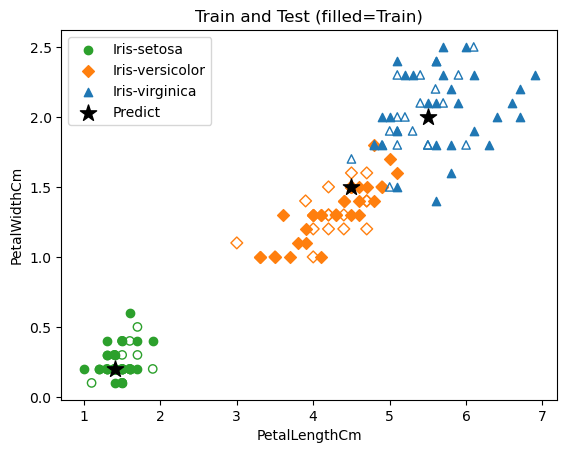

In [135]:
plot_dataset(train_df, test_df, predict_df, 'Train and Test (filled=Train)')


In [136]:
# Fit scaler on TRAIN only to avoid data leakage; then transform train/test/predict
scaler = StandardScaler()
scaler.fit(train_df[feature_cols])

# full scaled + keep target
df_scaled = pd.concat([
    pd.DataFrame(scaler.transform(df[feature_cols]), columns=feature_cols, index=df.index),
    df[[target_col]]
], axis=1)

train_scaled = df_scaled.loc[train_df.index]
test_scaled  = df_scaled.loc[test_df.index]
predict_scaled = pd.DataFrame(scaler.transform(predict_df[feature_cols]),
                              columns=feature_cols)


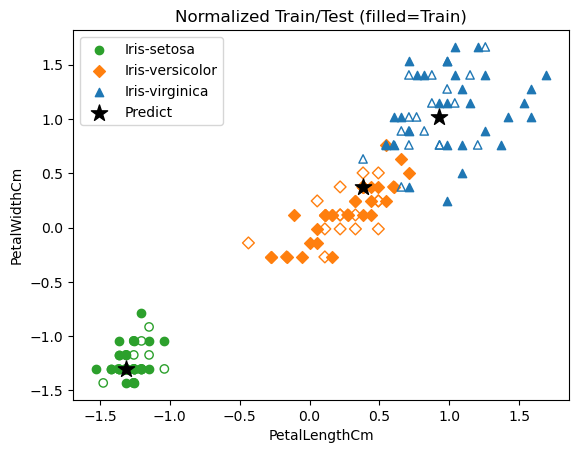

In [137]:
plot_dataset(train_scaled, test_scaled, predict_scaled.assign(Species='Predict'),
             'Normalized Train/Test (filled=Train)')


In [138]:
# KNN: try k=1..15 on TRAIN, evaluate on TEST; pick best k by test accuracy
Xtr, ytr = train_scaled[feature_cols], train_scaled[target_col]
Xte, yte = test_scaled[feature_cols],  test_scaled[target_col]

rows = []
for k in range(1, 16):
    knn = KNeighborsClassifier(n_neighbors=k).fit(Xtr, ytr)
    acc = accuracy_score(yte, knn.predict(Xte))
    rows.append({'k': k, 'accuracy': acc})

results = pd.DataFrame(rows)
results


,k,accuracy
0,1,0.950000
1,2,0.883333
2,3,0.916667
3,4,0.916667
4,5,0.950000
5,6,0.933333
6,7,0.950000
7,8,0.950000
8,9,0.950000
9,10,0.950000


In [139]:
best_k = int(results.loc[results['accuracy'].idxmax(), 'k'])
best_k


1

In [140]:
X_all = df_scaled[feature_cols]
y_all = df_scaled[target_col]

knn = KNeighborsClassifier(n_neighbors=best_k).fit(X_all, y_all)

# neighbors + predictions for new points
distances, indices = knn.kneighbors(predict_scaled)
preds = knn.predict(predict_scaled)

for i, pred in enumerate(preds):
    print('-'*64)
    print('Predicted:', pred)
    print('New point:', predict_df.iloc[i])
    print('\nNearest neighbors (original units):')
    print(df.iloc[indices[i], :])
    print('\nNearest neighbors (scaled):')
    print(df_scaled.iloc[indices[i], :])


----------------------------------------------------------------
Predicted: Iris-setosa
New point: SepalLengthCm    5.1
SepalWidthCm     3.5
PetalLengthCm    1.4
PetalWidthCm     0.2
Name: 0, dtype: float64

Nearest neighbors (original units):
   SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm      Species
0            5.1           3.5            1.4           0.2  Iris-setosa

Nearest neighbors (scaled):
   SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm      Species
0      -0.904935      1.088035      -1.312174     -1.301965  Iris-setosa
----------------------------------------------------------------
Predicted: Iris-versicolor
New point: SepalLengthCm    6.0
SepalWidthCm     2.9
PetalLengthCm    4.5
PetalWidthCm     1.5
Name: 1, dtype: float64

Nearest neighbors (original units):
    SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm          Species
78            6.0           2.9            4.5           1.5  Iris-versicolor

Nearest neighbors (scaled):
  

**KNN Result (this run):** Test accuracy ≈ 0.95.  
Most errors occur on the **versicolor ↔ virginica** boundary; setosa is perfect.


## Naive Bayes (GaussianNB)

**Idea:** within each class, each numeric feature is modeled as **Gaussian**; features are conditionally independent given the class.  
**Why Gaussian (not Multinomial):** Iris features are **continuous** (lengths/widths), not counts/dummies.  
**Procedure:** fit on train, predict on test; no tuning needed.


In [141]:
# GaussianNB: suitable for continuous features (Iris); fit on TRAIN, evaluate on TEST
nb = GaussianNB()
nb.fit(Xtr, ytr)

# predict on TEST split
y_pred_nb = nb.predict(Xte)

# metrics
acc_nb = accuracy_score(yte, y_pred_nb)
cm_nb  = confusion_matrix(yte, y_pred_nb, labels=['Iris-setosa','Iris-versicolor','Iris-virginica'])

print(f"GaussianNB — Test Accuracy: {acc_nb:.3f}\n")
print(pd.DataFrame(cm_nb,
        index=['true_setosa','true_versicolor','true_virginica'],
        columns=['pred_setosa','pred_versicolor','pred_virginica']))
print("\nClassification Report:")
print(classification_report(yte, y_pred_nb, digits=3))


GaussianNB — Test Accuracy: 0.967

                 pred_setosa  pred_versicolor  pred_virginica
true_setosa               20                0               0
true_versicolor            0               20               0
true_virginica             0                2              18

Classification Report:
                 precision    recall  f1-score   support

    Iris-setosa      1.000     1.000     1.000        20
Iris-versicolor      0.909     1.000     0.952        20
 Iris-virginica      1.000     0.900     0.947        20

       accuracy                          0.967        60
      macro avg      0.970     0.967     0.967        60
   weighted avg      0.970     0.967     0.967        60



In [142]:
nb_preds = nb.predict(predict_scaled)
nb_proba = nb.predict_proba(predict_scaled)

for i, (label, probs) in enumerate(zip(nb_preds, nb_proba)):
    print(f"Point {i}: predicted = {label},  P(setosa, versicolor, virginica) = {probs}")

Point 0: predicted = Iris-setosa,  P(setosa, versicolor, virginica) = [1.00000000e+00 1.41308890e-17 2.03424058e-25]
Point 1: predicted = Iris-versicolor,  P(setosa, versicolor, virginica) = [9.09272201e-102 9.93653662e-001 6.34633813e-003]
Point 2: predicted = Iris-virginica,  P(setosa, versicolor, virginica) = [6.24385016e-186 2.00299453e-004 9.99799701e-001]


**GaussianNB Result (this run):** Test accuracy = 0.967.  
Confusion: setosa 20/20, versicolor 20/20, virginica 18/20 (2 misclassified as versicolor).


## Logistic Regression (Multinomial)

**Idea:** learns **softmax probabilities** with a linear decision boundary across all 3 classes.  
**Settings:** `multi_class='multinomial'`, `solver='lbfgs'`, `max_iter=1000` (C very large to mirror “no regularization”).  
**Procedure:** fit on train, predict on test.

In [143]:
# Multinomial logistic regression: fit on TRAIN, evaluate on TEST (same split & scaling)
logit = LogisticRegression(
    penalty="l2",
    C=1e42,             
    solver="lbfgs",     
    multi_class="multinomial",
    max_iter=1000
)

# fit on TRAIN split
logit.fit(Xtr, ytr)

# predict on TEST split
y_pred_lr = logit.predict(Xte)

# metrics (same format as KNN/NB)
acc_lr = accuracy_score(yte, y_pred_lr)
cm_lr  = confusion_matrix(yte, y_pred_lr,
                          labels=['Iris-setosa','Iris-versicolor','Iris-virginica'])

print(f"Logistic Regression — Test Accuracy: {acc_lr:.3f}\n")
print(pd.DataFrame(cm_lr,
        index=['true_setosa','true_versicolor','true_virginica'],
        columns=['pred_setosa','pred_versicolor','pred_virginica']))
print("\nClassification Report:")
print(classification_report(yte, y_pred_lr, digits=3))


Logistic Regression — Test Accuracy: 0.967

                 pred_setosa  pred_versicolor  pred_virginica
true_setosa               20                0               0
true_versicolor            0               20               0
true_virginica             0                2              18

Classification Report:
                 precision    recall  f1-score   support

    Iris-setosa      1.000     1.000     1.000        20
Iris-versicolor      0.909     1.000     0.952        20
 Iris-virginica      1.000     0.900     0.947        20

       accuracy                          0.967        60
      macro avg      0.970     0.967     0.967        60
   weighted avg      0.970     0.967     0.967        60



In [144]:
proba_lr = logit.predict_proba(predict_scaled)
for i, (label, probs) in enumerate(zip(logit.predict(predict_scaled), proba_lr)):
    print(f"Point {i}: predicted = {label},  P(setosa, versicolor, virginica) = {probs}")


Point 0: predicted = Iris-setosa,  P(setosa, versicolor, virginica) = [1.00000000e+00 2.65133936e-23 9.15217316e-46]
Point 1: predicted = Iris-versicolor,  P(setosa, versicolor, virginica) = [1.36359363e-14 9.98026477e-01 1.97352307e-03]
Point 2: predicted = Iris-virginica,  P(setosa, versicolor, virginica) = [2.15243442e-27 3.60196152e-04 9.99639804e-01]



**Logistic Regression Result (this run):** Test accuracy = 0.967.  
Same pattern as NB: a couple of **virginica** near the boundary.


## Conclusion - Ranking (Best to Worst)

1) **Logistic Regression** = **Gaussian Naive Bayes** *(tie, ~0.967)*  
2) **KNN** *(~0.95)*

**Why:** LR and GaussianNB learn **smooth global boundaries** that match Iris structure; both classify **setosa** perfectly and only miss a couple of **virginica** near the **versicolor** border.  
KNN is strong but **depends on local neighbors**; borderline points can flip with nearby samples, so it makes a few more boundary errors.  
All models used the **same stratified split** and **scaler fit on train only** for a fair comparison.

